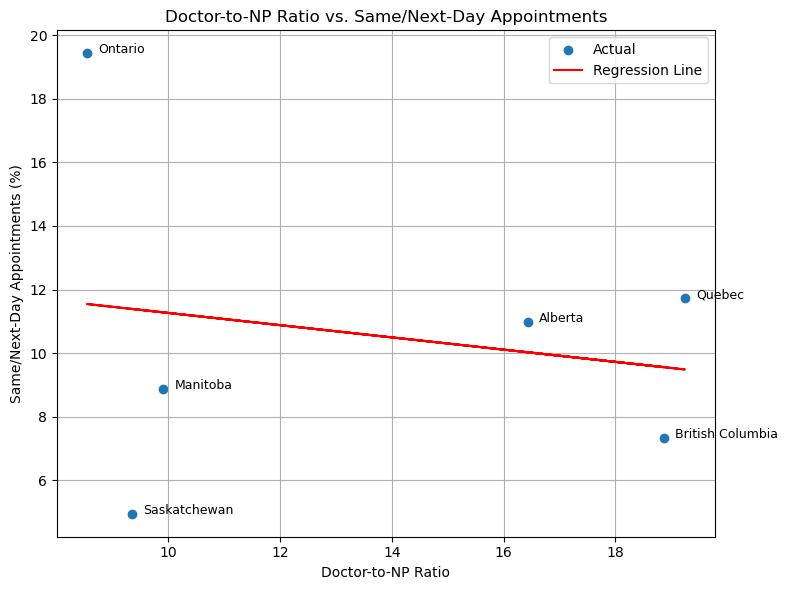

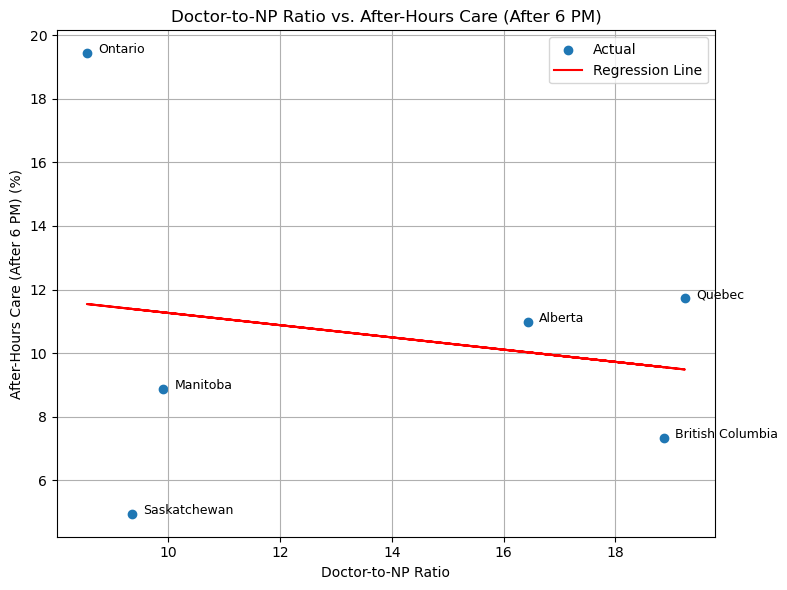

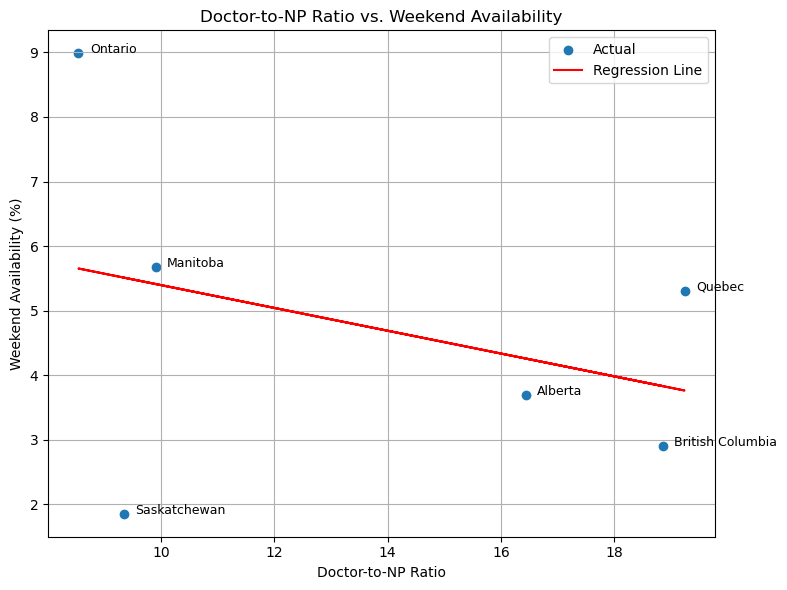

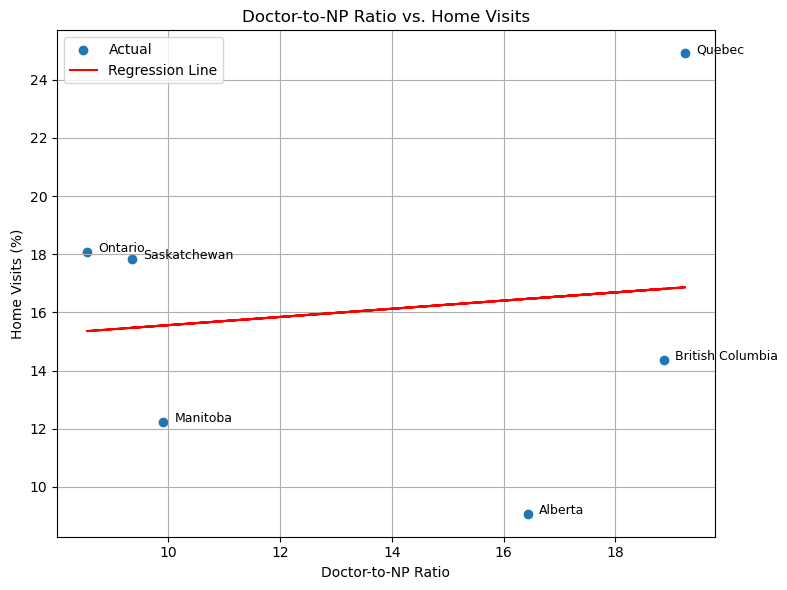

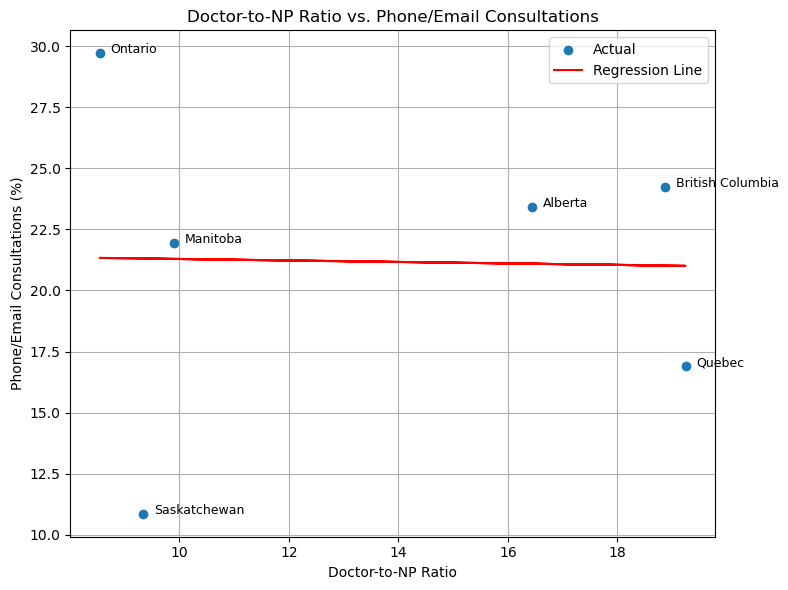

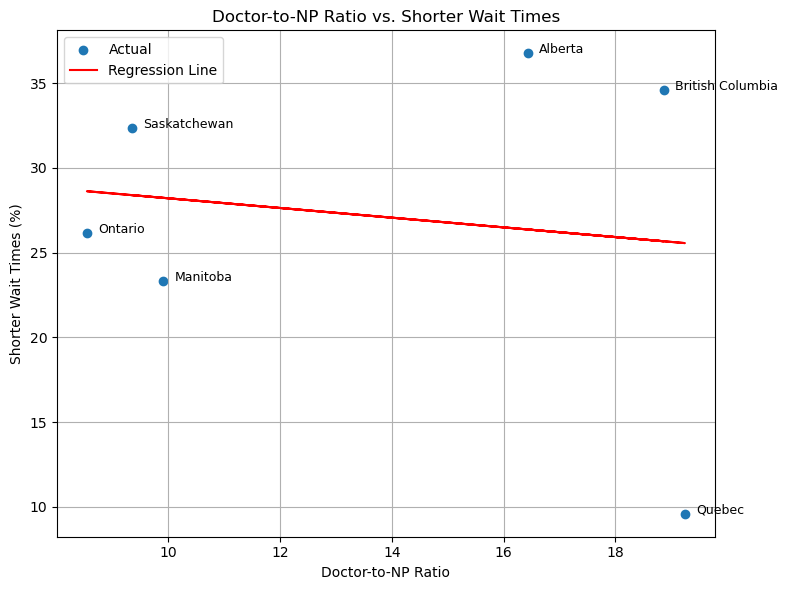

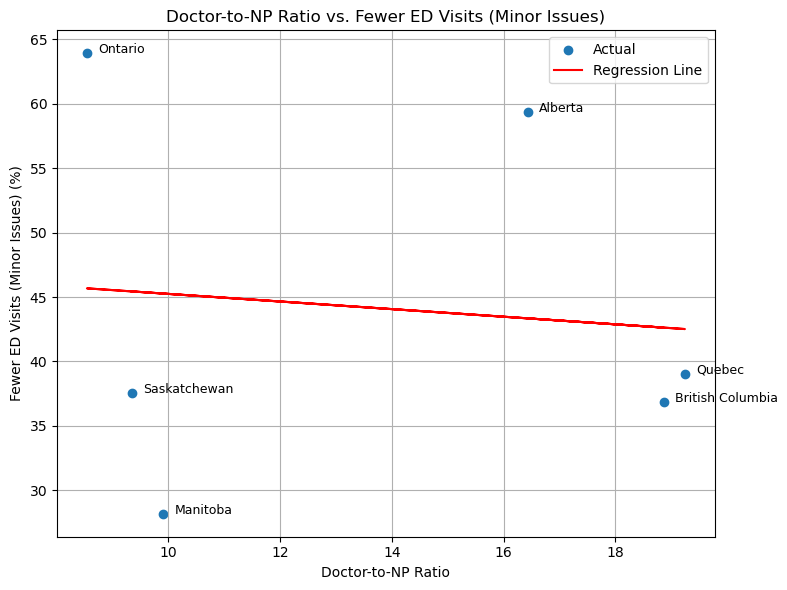


Regression Summary:
                           Metric     Slope  Intercept        R²
0      Same/Next-Day Appointments -0.192508  13.187530  0.036991
1   After-Hours Care (After 6 PM) -0.192508  13.187530  0.036991
2            Weekend Availability -0.176615   7.161522  0.121684
3                     Home Visits  0.140808  14.153161  0.016304
4       Phone/Email Consultations -0.030210  21.588445  0.000537
5              Shorter Wait Times -0.285999  31.059613  0.020485
6  Fewer ED Visits (Minor Issues) -0.295145  48.194877  0.010893


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from functools import reduce

# Load workforce data (placed in same directory as notebook)
workforce_path = "health-workforce-canada-2019-2023-overview-data-tables-en.xlsx"
workforce_data = {}
for i in range(6, 15):
    table_name = f"Table {i}"
    workforce_data[table_name] = pd.read_excel(workforce_path, sheet_name=table_name)

# Extract Doctor and NP counts
def extract_counts(df, province, count_col):
    df.columns = df.iloc[0]
    df = df[1:]
    df = df.rename(columns={df.columns[0]: "Type of professional"})
    df["Type of professional"] = df["Type of professional"].ffill()
    df_2022 = df[df["Year"] == 2022]

    def parse_count(row):
        try:
            return int(str(row[count_col]).replace("‡", "").replace("*", "").replace("—", "").strip())
        except:
            return None

    np_row = df_2022[df_2022["Type of professional"].str.contains("nurse practitioner", case=False, na=False)]
    doc_row = df_2022[df_2022["Type of professional"].str.lower() == "physicians"]

    np_count = parse_count(np_row.iloc[0]) if not np_row.empty else None
    doc_count = parse_count(doc_row.iloc[0]) if not doc_row.empty else None

    return {
        "Province": province,
        "Doctors": doc_count,
        "Nurse Practitioners": np_count,
        "Doctor-to-NP Ratio": doc_count / np_count if doc_count and np_count else None
    }

province_cols = {
    "Table 6": ("Quebec", "Quebec: Count"),
    "Table 7": ("Ontario", "Ontario: Count"),
    "Table 8": ("Manitoba", "Manitoba: Count"),
    "Table 9": ("Saskatchewan", "Saskatchewan: Count"),
    "Table 10": ("Alberta", "Alberta: Count"),
    "Table 11": ("British Columbia", "British Columbia: Count"),
    "Table 12": ("Yukon", "Yukon: Count"),
    "Table 13": ("Northwest Territories", "Northwest Territories: Count"),
    "Table 14": ("Nunavut", "Nunavut: Count")
}

doctor_np_data = [extract_counts(workforce_data[k], v[0], v[1]) for k, v in province_cols.items()]
doctor_np_df = pd.DataFrame(doctor_np_data)

# Load CMWF 2019 access data
cmwf_2019_path = "cmwf-2019-data-tables-en.xlsx"
access_data = {}
for i in range(12, 18):
    sheet = f"{i} Access to care"
    access_data[sheet] = pd.read_excel(cmwf_2019_path, sheet_name=sheet)

def extract_province_table(df, start_row=18):
    df_clean = df.iloc[start_row:].dropna(how='all').reset_index(drop=True)
    df_clean.columns = df_clean.iloc[0]
    return df_clean[1:]

province_map = {
    'N.L.': 'Newfoundland and Labrador',
    'P.E.I.': 'Prince Edward Island',
    'N.S.': 'Nova Scotia',
    'N.B.': 'New Brunswick',
    'Que.': 'Quebec',
    'Ont.': 'Ontario',
    'Man.': 'Manitoba',
    'Sask.': 'Saskatchewan',
    'Alta.': 'Alberta',
    'B.C.': 'British Columbia',
    'Y.T.': 'Yukon',
    'N.W.T.': 'Northwest Territories',
    'Nvt.': 'Nunavut'
}

access_tables = []
for name, df in access_data.items():
    cleaned = extract_province_table(df)
    cleaned.columns = ['Province'] + [f"{name}_Q{i+1}" for i in range(len(cleaned.columns)-1)]
    cleaned['Province'] = cleaned['Province'].map(province_map)
    access_tables.append(cleaned)

access_df = reduce(lambda left, right: pd.merge(left, right, on="Province", how="outer"), access_tables)
merged_df = pd.merge(access_df, doctor_np_df, on="Province", how="inner")
merged_df_clean = merged_df.dropna(subset=["Doctor-to-NP Ratio"])

# Define metrics to analyze
correlation_targets = {
    "Same/Next-Day Appointments": "12 Access to care_Q1",
    "After-Hours Care (After 6 PM)": "12 Access to care_Q1",  # Same metric
    "Weekend Availability": "13 Access to care_Q1",
    "Home Visits": "17 Access to care_Q1",
    "Phone/Email Consultations": "16 Access to care_Q1",
    "Shorter Wait Times": "15 Access to care_Q1",
    "Fewer ED Visits (Minor Issues)": "14 Access to care_Q1"
}

# Analyze correlation + linear regression
regression_results = []

for label, column in correlation_targets.items():
    if column not in merged_df_clean.columns:
        continue

    df = merged_df_clean[["Doctor-to-NP Ratio", column, "Province"]].dropna()
    X = df[["Doctor-to-NP Ratio"]].astype(float).values
    y = df[column].astype(float).values

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(X, y)

    regression_results.append({
        "Metric": label,
        "Slope": slope,
        "Intercept": intercept,
        "R²": r_squared
    })

    # Plot the regression
    plt.figure(figsize=(8, 6))
    plt.scatter(X, y, label="Actual")
    plt.plot(X, y_pred, color="red", label="Regression Line")
    for _, row in df.iterrows():
        plt.text(row["Doctor-to-NP Ratio"] + 0.2, row[column], row["Province"], fontsize=9)
    plt.xlabel("Doctor-to-NP Ratio")
    plt.ylabel(f"{label} (%)")
    plt.title(f"Doctor-to-NP Ratio vs. {label}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Summary of results
regression_summary_df = pd.DataFrame(regression_results)
print("\nRegression Summary:")
print(regression_summary_df)



In [ ]:
1. Objectives
Do provinces with a higher ratio of Nurse Practitioners (NPs) relative to Doctors have better access to primary care?
•	Quantify the relationship between Doctor-to-NP ratios and primary care access indicators
•	Use correlation and linear regression to determine if increasing NP presence improves:
o	Appointment access
o	After-hours & weekend care
o	Home visit options
o	Phone/email consultations
o	Wait times
o	Avoidable ER visits
Hypothesis:
Lower Doctor-to-NP ratios (i.e., more NPs per doctor) are associated with improved access to care.
2. Analysis
Data Sources:
•	Health Workforce Canada (2019–2023): Number of doctors and NPs per province (2022 values).
•	Commonwealth Fund (2019): Access-to-care survey results at the provincial level.
Key Metrics Analyzed:
7 access-to-care indicators examined:
          
Metric	CMWF Column	What It Measures
1. Same/Next-Day Appointments	Q12_Q1	Timely access to care
2. After-Hours Care (after 6 PM)	Q12_Q1	Evening appointment availability
3. Weekend Availability	Q13_Q1	Access on Saturdays/Sundays
4. Home Visits	Q17_Q1	Proportion of providers offering in-home care
5. Phone/Email Consultations	Q16_Q1	Digital communication access
6. Shorter Wait Times	Q15_Q1	Timeliness of follow-up or care
7. Fewer ED Visits (Minor Issues)	Q14_Q1	Availability of alternatives to emergency rooms


    
Methodology:
•	Calculated Doctor-to-NP Ratio = Doctors / Nurse Practitioners (per province)
•	Merged ratio data with access metrics
•	Ran simple linear regression for each access metric:
Access Metric=β0+β1×(Doctor-to-NP Ratio)\text{Access Metric} = \beta_0 + \beta_1 \times (\text{Doctor-to-NP Ratio})Access Metric=β0+β1×(Doctor-to-NP Ratio) 
•	Plotted scatter plots with regression lines
•	Evaluated:
o	Slope (β₁): Direction of relationship
o	R²: Proportion of variation explained


Metric	                            Slope	                    Intercept	          R²	                               Interpretation
Same/Next-Day Appointments	         -0.193                   	13.19	               0.037	                   Weak negative link: More NPs → better same-day access
After-Hours Care (After 6 PM)	     -0.193                  	13.19                	0.037	                        Same as above (uses same data)
Weekend Availability	              -0.177	                7.16                  	0.122	                   Stronger relationship: More NPs → more weekend access
Home Visits	                            +0.141	               14.15	                 0.016	                  Weak positive trend: More NPs might expand outreach
Phone/Email Consultations             	-0.030	               21.59	               0.001	                        No meaningful relationship
Shorter Wait Times	                      -0.286	           31.06	               0.020	                              Slightly better wait times with more NPs
Fewer ED Visits (Minor Issues)	         -0.295	                8.19	               0.011	                     Minor correlation: more NPs may reduce ER reliance


                                                    
🔹 Metric 1: Same/Next-Day Appointments
To assess whether provinces with more NPs per doctor are better at offering same-day or next-day appointments to patients — a key indicator of timely primary care access.
•	A negative slope means that lower doctor-to-NP ratios (i.e., more NPs) are associated with higher same-day access.
•	But the low R² (3.7%) shows a very weak linear relationship.
Conclusions:
•	More NPs may slightly improve same-day access, but this metric is not strongly predicted by workforce mix alone.
•	Clinic structure, triage systems, or regional demand may play larger roles.


🔹 Metric 2: After-Hours Care (After 6 PM)
To determine whether provinces with more NPs per doctor offer better access to evening appointments (after 6 PM).

Conclusions:
•	There’s a minor trend suggesting NPs help support evening care.
•	Still, not a strong or statistically reliable predictor on its own.


🔹 Metric 3: Weekend Availability
To examine if provinces with more NPs offer Saturday/Sunday appointment availability.

Conclusions:
•	This metric shows the strongest correlation in the dataset.
•	Provinces with more NPs relative to doctors are more likely to offer weekend care.
•	This may reflect how NPs improve clinic flexibility, staff rotation, or extended-hour coverage


🔹 Metric 4: Home Visits
To see whether a higher NP presence leads to more practices offering home visits, which improve access for elderly, rural, or mobility-limited patients.
Conclusions:
•	This was the only metric with a positive slope.
•	Suggests a weak trend that more NPs may lead to more home-based care.
•	NPs may be more likely to participate in community outreach models — but again, the effect is minimal.


🔹 Metric 5: Phone/Email Consultations
To test whether provinces with more NPs enable better digital or remote communication access (phone/email consults).
 •	No meaningful correlation was found.
•	Digital access likely depends more on:
o	Clinic technology
o	Provincial telehealth policies
o	Infrastructure investments (not workforce mix)


🔹 Metric 6: Shorter Wait Times
To assess whether provinces with more NPs report shorter wait times for care.
Conclusions:
•	Suggests some reduction in wait times where NPs are more available.
•	However, the explanatory power is very low (only 2% of variation explained).
•	May reflect that scheduling systems, demand, or care models have a stronger influence.

🔹 Metric 7: Fewer Emergency Department Visits (for Minor Issues)
To see whether better primary care access (more NPs) is associated with fewer avoidable ER visits.

Conclusions:
•	Very weak trend that more NPs → fewer ER visits for minor conditions.
•	Suggests that access alone isn’t enough — patient behavior, education, or walk-in alternatives may be more important.


Metric	                             Strength of Link with NP Ratio	                                     Key Insight
Weekend Availability	                         Strongest	                                       More NPs = better weekend care
Same-Day / After-Hours Access	                    Weak	                                          Slight improvement only
Home Visits	                                     Weak positive	                                   NPs may support outreach care
Wait Times / ER Visits                          	Very weak	                                      More factors at play
Phone/Email Consults	                            None	                                        Influenced by tech, not staff

                                                        